In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import logging 
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from collections import defaultdict
from math import sqrt
from multiprocessing.dummy import Pool as ThreadPool 
import numpy as np
from vanet_tools import plot_microclouds,Block,Node,Microcloud

In [2]:
df = pd.read_csv("new_york.csv",delimiter=";").dropna()

We have to check if the simulation ended with some cars still on it. The last second in the simulation as reported in the SUMO-GUI was around 4600s.

In [21]:
max_time = df['timestep_time'].max()
max_time

4468.0

Therefore, all the cars departed before the simulation finished

In [5]:
car_groups = df.sort_values(by='timestep_time').groupby('vehicle_id')

In [6]:
CARS = df['vehicle_id'].unique()

In [5]:
car0_df = car_groups.get_group(CARS[0])
car0_df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y
0,0.0,208.92,veh0,46525058#0_0,5.10,0.0,0.00,passenger,3764.34,5531.80
1,1.0,208.92,veh0,46525058#0_0,6.54,0.0,1.44,passenger,3763.65,5530.53
3,2.0,208.92,veh0,46525058#0_0,10.52,0.0,3.98,passenger,3761.72,5527.05
6,3.0,208.92,veh0,46525058#0_0,16.34,0.0,5.82,passenger,3758.91,5521.96
9,4.0,208.92,veh0,46525058#0_0,24.43,0.0,8.09,passenger,3754.99,5514.87


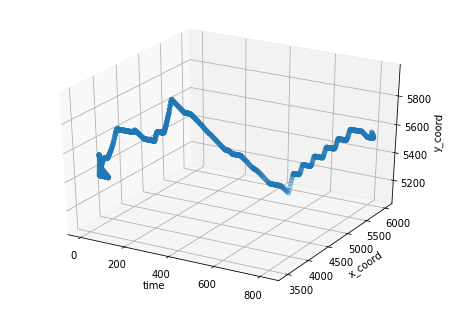

In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(car0_df['timestep_time'],car0_df['vehicle_x'] , car0_df['vehicle_y'])
ax.set_xlabel("time")
ax.set_ylabel("x_coord")
ax.set_zlabel("y_coord")
plt.show()

In [7]:
coordinates = df[['vehicle_x','vehicle_y']]

In [8]:
coords_x,coords_y = coordinates['vehicle_x'],coordinates['vehicle_y']

In [9]:
coords_x.min(),coords_y.min()

(2709.8, 3612.22)

In [10]:
coords_x.max(),coords_y.max()

(7535.23, 8296.82)

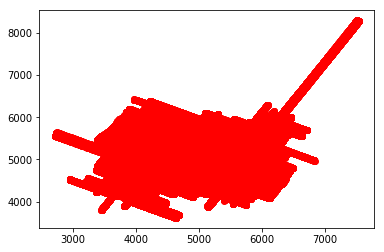

In [11]:
plt.scatter(coords_x,coords_y,c='red')
plt.show()

Below we will place the mircroclouds into the grid.Our algorithm for doing so works as follows. We will get a random coordinate and see if that coordinate collides overlaps with any of the current coordinates for the microclouds, if it does not the position is added onto the array as a position for a microcloud

In [10]:
def create_coords(num_microclouds,coordinates,microcloud_range):
    microclouds_coords =  []
    while(len(microclouds_coords)<num_microclouds):
        random_coord = coordinates.sample().get_values()[0]
        overlaps = False
        for coord in microclouds_coords:
            if distance.euclidean(coord, random_coord)<microcloud_range: 
                overlaps = True
                break
        if not overlaps:
            microclouds_coords.append(random_coord)
    return microclouds_coords

In [11]:
MICROCLOUD_RANGE=150
NUM_MICROCLOUDS = 100

In [13]:
MICROCLOUD_COORDS = create_coords(NUM_MICROCLOUDS,coordinates,MICROCLOUD_RANGE)

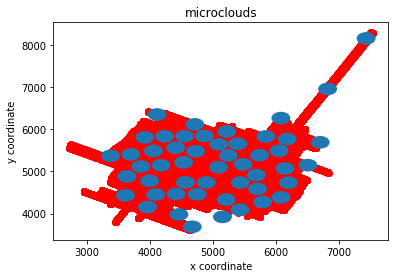

In [40]:
plot_microclouds(microclouds_coords,MICROCLOUD_RANGE,coords_x,coords_y)

In [14]:
#We estimate that the average block will take 5 seconds to download. Therefore bandwith=1 and block_size =5.
def simulation(microclouds_coords=MICROCLOUD_COORDS,cars=CARS,total_blocks = 12,blocks_per_microcloud= 3,bandwith = 1,block_size = 5):
    blocks = [Block(i,block_size) for i in range(total_blocks)]
    microclouds = []
    block_index = 0
    for i,coord in enumerate(microclouds_coords):
        microcloud_blocks = []
        for b in range(blocks_per_microcloud):
            block = blocks[block_index]
            block_index+=1
            block_index%=len(blocks)
            microcloud_blocks.append(block)
        microcloud = Microcloud(i,coord[0],coord[1],MICROCLOUD_RANGE,microcloud_blocks,bandwith)
        microclouds.append(microcloud)
    nodes = []
    for car in cars:
        car_df = car_groups.get_group(car)
        node = Node(car_df,blocks)
        nodes.append(node)
    logging.info("Finished setup started simulation with {} microclouds".format(len(microclouds_coords)))
    pool = ThreadPool(8) 
    results = pool.map(lambda node:node.simulate(microclouds), nodes)
    return results

In [38]:
#This is a test of the simulation with 1 car
logging.getLogger().setLevel(logging.DEBUG)
result = simulation(cars=[CARS[0]])

INFO:root:Finished setup started simulation with 50 microclouds
DEBUG:root:Id veh0
DEBUG:root:Time 0.0
DEBUG:root:Initiated download for block 3 on car veh0 with microcloud 37
DEBUG:root:Time 1.0
DEBUG:root:Continuing download for block 3 on car veh0 with microcloud 37 latest progress: 1
DEBUG:root:Time 2.0
DEBUG:root:Continuing download for block 3 on car veh0 with microcloud 37 latest progress: 2
DEBUG:root:Time 3.0
DEBUG:root:Initiated download for block 3 on car veh0 with microcloud 1
DEBUG:root:Continuing download for block 3 on car veh0 with microcloud 37 latest progress: 3
DEBUG:root:Time 4.0
DEBUG:root:Continuing download for block 3 on car veh0 with microcloud 1 latest progress: 4
DEBUG:root:Continuing download for block 3 on car veh0 with microcloud 37 latest progress: 5
DEBUG:root:Download finished for block 3 on car veh0 with microcloud 37
DEBUG:root:Time 5.0
DEBUG:root:Continuing download for block 3 on car veh0 with microcloud 1 latest progress: 6
DEBUG:root:Download fini

DEBUG:root:Time 113.0
DEBUG:root:Continuing download for block 8 on car veh0 with microcloud 2 latest progress: 2
DEBUG:root:Time 114.0
DEBUG:root:Continuing download for block 8 on car veh0 with microcloud 2 latest progress: 3
DEBUG:root:Time 115.0
DEBUG:root:Continuing download for block 8 on car veh0 with microcloud 2 latest progress: 4
DEBUG:root:Time 116.0
DEBUG:root:Continuing download for block 8 on car veh0 with microcloud 2 latest progress: 5
DEBUG:root:Download finished for block 8 on car veh0 with microcloud 2
DEBUG:root:Time 117.0
DEBUG:root:Time 118.0
DEBUG:root:Time 119.0
DEBUG:root:Time 120.0
DEBUG:root:Time 121.0
DEBUG:root:Time 122.0
DEBUG:root:Time 123.0
DEBUG:root:Time 124.0
DEBUG:root:Time 125.0
DEBUG:root:Time 126.0
DEBUG:root:Time 127.0
DEBUG:root:Time 128.0
DEBUG:root:Time 129.0
DEBUG:root:Time 130.0
DEBUG:root:Time 131.0
DEBUG:root:Time 132.0
DEBUG:root:Time 133.0
DEBUG:root:Time 134.0
DEBUG:root:Time 135.0
DEBUG:root:Time 136.0
DEBUG:root:Time 137.0
DEBUG:root:

DEBUG:root:Download finished for block 9 on car veh0 with microcloud 43
DEBUG:root:Time 444.0
DEBUG:root:Initiated download for block 10 on car veh0 with microcloud 43
DEBUG:root:Time 445.0
DEBUG:root:Continuing download for block 10 on car veh0 with microcloud 43 latest progress: 1
DEBUG:root:Time 446.0
DEBUG:root:Continuing download for block 10 on car veh0 with microcloud 43 latest progress: 2
DEBUG:root:Time 447.0
DEBUG:root:Continuing download for block 10 on car veh0 with microcloud 43 latest progress: 3
DEBUG:root:Time 448.0
DEBUG:root:Continuing download for block 10 on car veh0 with microcloud 43 latest progress: 4
DEBUG:root:Time 449.0
DEBUG:root:Continuing download for block 10 on car veh0 with microcloud 43 latest progress: 5
DEBUG:root:Download finished for block 10 on car veh0 with microcloud 43
DEBUG:root:Time 450.0
DEBUG:root:Initiated download for block 11 on car veh0 with microcloud 43
DEBUG:root:Time 451.0
DEBUG:root:Continuing download for block 11 on car veh0 with 

DEBUG:root:Time 758.0
DEBUG:root:Time 759.0
DEBUG:root:Time 760.0
DEBUG:root:Time 761.0
DEBUG:root:Time 762.0
DEBUG:root:Time 763.0
DEBUG:root:Time 764.0
DEBUG:root:Time 765.0
DEBUG:root:Time 766.0
DEBUG:root:Time 767.0
DEBUG:root:Time 768.0
DEBUG:root:Time 769.0
DEBUG:root:Time 770.0
DEBUG:root:Time 771.0
DEBUG:root:Time 772.0
DEBUG:root:Time 773.0
DEBUG:root:Time 774.0
DEBUG:root:Time 775.0
DEBUG:root:Time 776.0
DEBUG:root:Time 777.0
DEBUG:root:Time 778.0
DEBUG:root:Time 779.0
DEBUG:root:Time 780.0
DEBUG:root:Time 781.0
DEBUG:root:Time 782.0
DEBUG:root:Time 783.0
DEBUG:root:Time 784.0
DEBUG:root:Time 785.0
DEBUG:root:Time 786.0
DEBUG:root:Time 787.0
DEBUG:root:Time 788.0
DEBUG:root:Time 789.0
DEBUG:root:Time 790.0
DEBUG:root:Time 791.0
DEBUG:root:Time 792.0
DEBUG:root:Time 793.0
DEBUG:root:Time 794.0
DEBUG:root:Time 795.0
DEBUG:root:Time 796.0
DEBUG:root:Time 797.0
DEBUG:root:Time 798.0
DEBUG:root:Time 799.0
DEBUG:root:Time 800.0
DEBUG:root:Time 801.0
DEBUG:root:Time 802.0
DEBUG:root

In [17]:
result

[['veh0', 12, 12]]

In [18]:
logging.getLogger().setLevel(logging.INFO)
results = simulation()

INFO:root:Finished setup started simulation with 50 microclouds


In [20]:
stats_df = pd.DataFrame(results,columns=['id','blocks_received','blocks_needed'])
stats_df

,id,blocks_received,blocks_needed
0,veh0,12,12
1,veh1,6,12
2,veh2,9,12
3,veh3,9,12
4,veh4,9,12
5,veh5,8,12
6,veh6,12,12
7,veh7,9,12
8,veh9,8,12
9,veh10,9,12


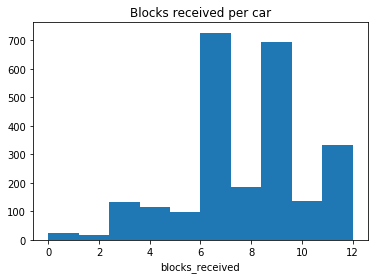

In [23]:
blocks_received = stats_df['blocks_received']
plt.xlabel("blocks_received")
plt.title("Blocks received per car")
plt.hist(stats_df['blocks_received'])
plt.show()

In [33]:
block_percentage = blocks_received.mean()/12
ninety_five_percentily = np.percentile(blocks_received,5)
block_percentage,ninety_five_percentily

(0.6408617424242424, 3.0)

In [15]:
def simulation_by_number_of_clouds():
    logging.getLogger().setLevel(logging.INFO)
    stats = []
    for num_clouds in range(1,101):
        logging.info("Starting simulation with {} num of clouds".format(num_clouds))
        microclouds_coords = create_coords(num_clouds,coordinates,MICROCLOUD_RANGE)
        results = simulation(microclouds_coords=microclouds_coords)
        stats_df = pd.DataFrame(results,columns=['id','blocks_received','blocks_needed'])
        blocks_received = stats_df['blocks_received']
        block_percentage = blocks_received.mean()/12
        ninety_five_percentily = np.percentile(blocks_received,5)
        stats.append([num_clouds,block_percentage,ninety_five_percentily])
    return stats
        

In [ ]:
stats = simulation_by_number_of_clouds()

INFO:root:Starting simulation with 1 num of clouds
INFO:root:Finished setup started simulation with 1 microclouds
INFO:root:Starting simulation with 2 num of clouds
INFO:root:Finished setup started simulation with 2 microclouds
INFO:root:Starting simulation with 3 num of clouds
INFO:root:Finished setup started simulation with 3 microclouds
INFO:root:Starting simulation with 4 num of clouds
INFO:root:Finished setup started simulation with 4 microclouds
INFO:root:Starting simulation with 5 num of clouds
INFO:root:Finished setup started simulation with 5 microclouds
INFO:root:Starting simulation with 6 num of clouds
INFO:root:Finished setup started simulation with 6 microclouds
INFO:root:Starting simulation with 7 num of clouds
INFO:root:Finished setup started simulation with 7 microclouds
INFO:root:Starting simulation with 8 num of clouds
INFO:root:Finished setup started simulation with 8 microclouds
INFO:root:Starting simulation with 9 num of clouds
INFO:root:Finished setup started simu

INFO:root:Starting simulation with 72 num of clouds
INFO:root:Finished setup started simulation with 72 microclouds
INFO:root:Starting simulation with 73 num of clouds
INFO:root:Finished setup started simulation with 73 microclouds
INFO:root:Starting simulation with 74 num of clouds
INFO:root:Finished setup started simulation with 74 microclouds
INFO:root:Starting simulation with 75 num of clouds
INFO:root:Finished setup started simulation with 75 microclouds
INFO:root:Starting simulation with 76 num of clouds
INFO:root:Finished setup started simulation with 76 microclouds
INFO:root:Starting simulation with 77 num of clouds
INFO:root:Finished setup started simulation with 77 microclouds
INFO:root:Starting simulation with 78 num of clouds
INFO:root:Finished setup started simulation with 78 microclouds
